In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from skimage.transform import resize

from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.opflow import StateFn, Gradient, I, Z
from qiskit.utils import QuantumInstance

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

In [2]:
qasm_sim = Aer.get_backend('qasm_simulator')
qinst = QuantumInstance(qasm_sim, 2048)

In [3]:
fn = 'data_banknote_authentication.txt'
data = np.loadtxt(fn,dtype=float,delimiter=',')
X = data[:,:-1]
y = data[:,-1]
test_ratio= 0.2
seed = 3897
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=seed, stratify=y)

(1097, 4)
(275, 4)
(1097,)
(275,)


In [4]:
def prepare_dataset(labels, num_instances, test_ratio, seed):
    mnist = datasets.load_digits()
    num_classes = len(labels)

    # Filter digits and targets
    x = mnist.images[[t in labels for t in mnist.target]]
    y = mnist.target[[t in labels for t in mnist.target]]

    # We keep only `num_instances` images for each label
    x = np.concatenate([x[y == labels[lbl]][:num_instances] for lbl in labels], axis=0)
    y = np.concatenate([y[y == labels[lbl]][:num_instances] for lbl in labels], axis=0)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=seed, stratify=y)

    return x_train, x_test, y_train, y_test

def image_resize(x, size):
    # https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize
    return np.vstack([[resize(x_i, (size, 1), anti_aliasing=False) for x_i in x]])


In [5]:
labels = [0, 1]
num_instances = 50
test_ratio = 0.2
seed = 3897


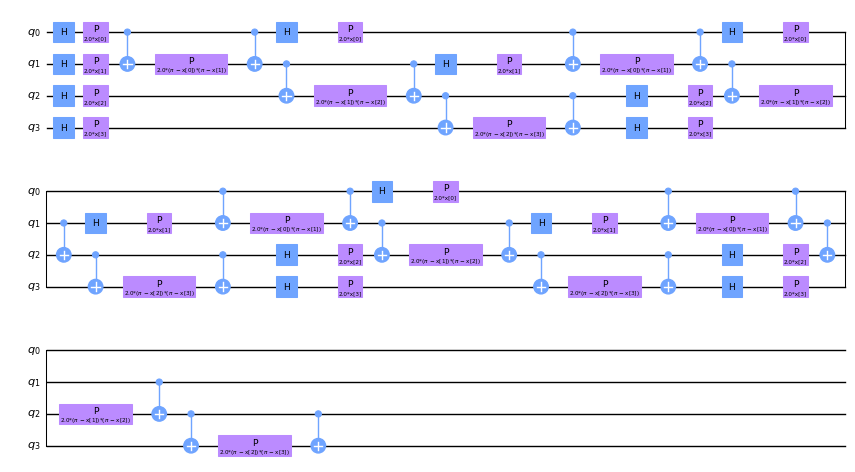

In [6]:
def get_zz_feature_map(feature_dim, feature_map_rep, ent):
    return ZZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent)

fmap_zz = get_zz_feature_map(4, 4, 'linear')
fmap_zz.decompose().draw('mpl', scale=0.7)

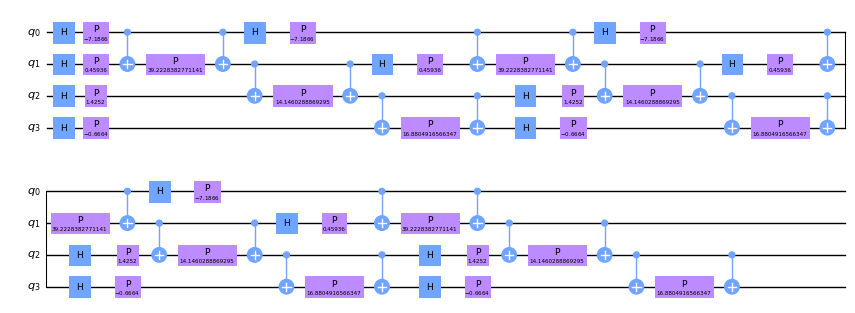

In [7]:
fmap_zz.assign_parameters({k:v for (k,v) in zip(fmap_zz.parameters, x_train[0])}).decompose().draw('mpl', scale=0.7)

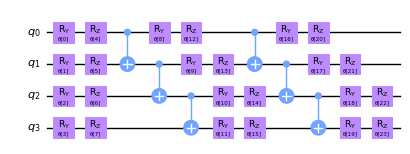

In [8]:
def get_two_locals(feature_dim, rotations, var_form_rep, ent):
    return TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)

ansatz_tl = get_two_locals(4, ['ry', 'rz'], 2, 'linear')
ansatz_tl.decompose().draw('mpl', scale=0.7)

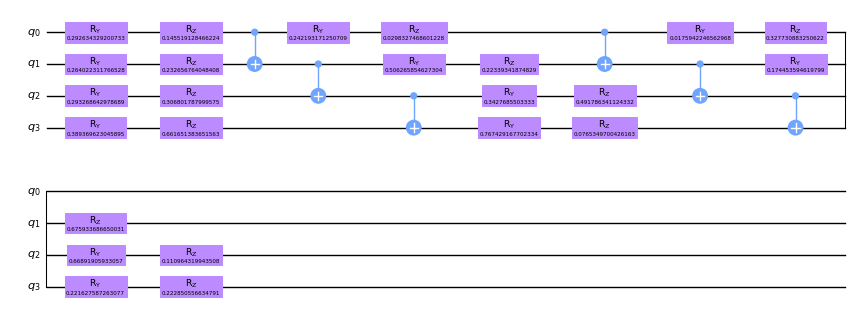

In [9]:
weights = np.random.random(len(ansatz_tl.parameters))
ansatz_tl.assign_parameters({k:v for (k,v) in zip(ansatz_tl.parameters, weights)}).decompose().draw('mpl', scale=0.7)

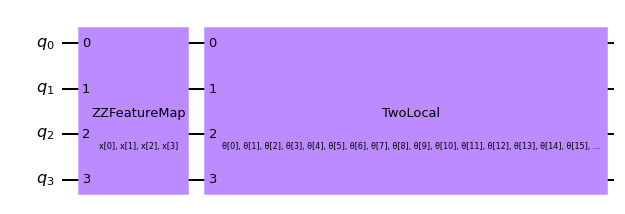

In [10]:
var_circuit = fmap_zz.compose(ansatz_tl)
var_circuit.draw('mpl')

In [11]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [12]:
num_classes = 2
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap_zz.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz_tl.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [13]:
# The result of the neural network of the shape (output_shape).
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.36376953, 0.63623047]])

In [14]:
# The result of the neural network of the backward pass, i.e., a tuple with the gradients
# for input and weights of shape (output_shape, num_input) and
# (output_shape, num_weights), respectively.
_, update = qnn.backward(x_train[0], weights)
update

array([[[-0.02636719,  0.02197266,  0.0065918 ,  0.00708008,
         -0.00366211, -0.00317383, -0.00634766, -0.00341797,
          0.13037109, -0.0065918 , -0.00805664,  0.00073242,
         -0.00976563,  0.01025391, -0.00683594, -0.00097656,
         -0.12670898,  0.00439453,  0.01489258, -0.00244141,
         -0.00488281,  0.00488281,  0.00097656,  0.00268555],
        [ 0.02636719, -0.02197266, -0.0065918 , -0.00708008,
          0.00366211,  0.00317383,  0.00634766,  0.00341797,
         -0.13037109,  0.0065918 ,  0.00805664, -0.00073242,
          0.00976563, -0.01025391,  0.00683594,  0.00097656,
          0.12670898, -0.00439453, -0.01489258,  0.00244141,
          0.00488281, -0.00488281, -0.00097656, -0.00268555]]])

In [15]:
obs_parity = Z ^ 4
obs_one_qubit = I ^ (4 - 1) ^ Z
obs_one_qubit

PauliOp(Pauli('IIIZ'), coeff=1.0)

In [16]:
# For an introduction to the Opflow module, see
# https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/operators/01_operator_flow.ipynb
operator = ~StateFn(obs_one_qubit) @ StateFn(var_circuit)
operator

ComposedOp([OperatorStateFn(PauliOp(Pauli('IIIZ'), coeff=1.0), coeff=1.0, is_measurement=True), CircuitStateFn(<qiskit.circuit.library.data_preparation.zz_feature_map.ZZFeatureMap object at 0x0000017A74156D30>, coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False)

In [17]:
gradient = Gradient(grad_method="param_shift")
op_qnn = OpflowQNN(operator,
                   input_params=fmap_zz.parameters,
                   weight_params=ansatz_tl.parameters,
                   gradient=gradient,
                   quantum_instance=qinst)

In [18]:
output = op_qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 1)


array([[-0.2109375]])

In [19]:
_, update = op_qnn.backward(x_train[0], weights)
print(update.shape)
update

(1, 1, 24)


array([[[-0.03662109,  0.03320312,  0.0078125 ,  0.015625  ,
          0.02929688, -0.01757812, -0.01611328,  0.02392578,
          0.29394531, -0.01953125, -0.00585938,  0.00683594,
         -0.00683594,  0.02246094,  0.02636719,  0.02685547,
         -0.26757812,  0.00146484, -0.00488281,  0.01220703,
         -0.02246094,  0.01123047, -0.00292969,  0.01464844]]])

In [20]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [21]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

In [22]:
max_itr = 10
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


x_train_norm = np.array([x/np.linalg.norm(x) for x in x_train])

vqc = vqc.fit(x_train_norm, y_train_1h)

3 - 1112.673133086729
6 - 1110.942609760146
9 - 1086.2409489925972
12 - 1081.5565631817994
15 - 1054.3851425291964
18 - 1055.771585627821
21 - 1056.1383015636745
24 - 1049.345896339735
27 - 1021.5800723159324
30 - 1021.6989500335327


In [23]:
score_train = vqc.score(x_train, y_train_1h)
score_test = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.5004557885141294
Score on the test set 0.5381818181818182
